# <h1 align="center">Trabajo Practico 1: UdeSA Panoramica</h1>

In [1]:
import matplotlib.pyplot as plt
import cv2
from utils import imshow, show_images
import numpy as np
from scipy.spatial import cKDTree

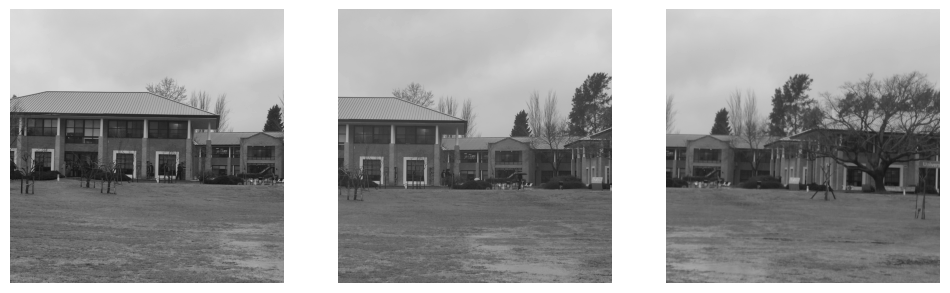

In [2]:
images = [cv2.imread(f'img/udesa_{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(3)]
show_images(images)

## Deteccion y Descripcion de Caracteristicas Visuales

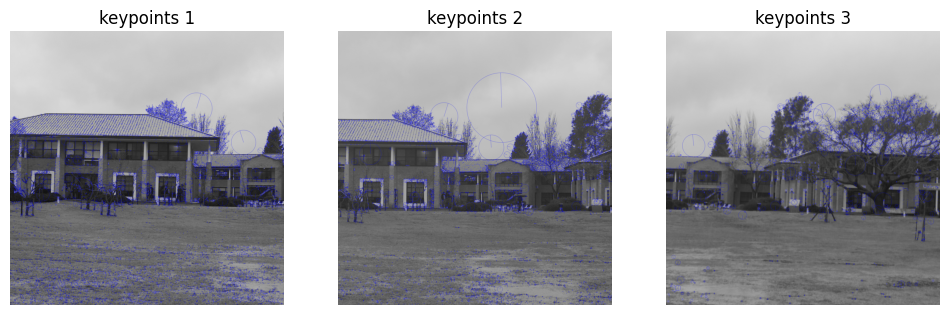

In [3]:
sift_algo = cv2.SIFT_create()
images_keypoints = []
images_descriptors = []

for i in range(len(images)):
    kp, des = sift_algo.detectAndCompute(images[i], None)
    images_keypoints.append(kp)
    images_descriptors.append(des)

images_with_kp = []
for i in range(len(images)):
    img_bgr = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR)
    img_with_kp = cv2.drawKeypoints(
        img_bgr,
        images_keypoints[i],
        0, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    images_with_kp.append(img_with_kp)

show_images(images_with_kp, ["keypoints 1", "keypoints 2", "keypoints 3"])

In [4]:
def non_max_suppression(keypoints, descriptors, nms_radius=10, max_kp=10000):
    if not keypoints:
        return [], None

    pts = np.array([kp.pt for kp in keypoints])
    responses = np.array([kp.response for kp in keypoints])
    
    order = np.argsort(-responses)
    
    tree = cKDTree(pts)
    suppressed = np.zeros(len(keypoints), dtype=bool)
    keep = []
    
    for i in order:
        if suppressed[i]:
            continue
        keep.append(i)
        if len(keep) >= max_kp:
            break
        
        neighbors = tree.query_ball_point(pts[i], nms_radius)
        suppressed[neighbors] = True

    filtered_keypoints = [keypoints[i] for i in keep]
    filtered_descriptors = descriptors[keep] if descriptors is not None else None
    
    return filtered_keypoints, filtered_descriptors


    
for i in range(len(images_keypoints)):
    images_keypoints[i], images_descriptors[i] = non_max_suppression(
        images_keypoints[i],
        images_descriptors[i],
        nms_radius=10,
        max_kp=10000
    )


## Asociacion de Caracteristicas

### Cross-check

Matches between image 0 and image 1: 2128
Matches between image 1 and image 2: 1087


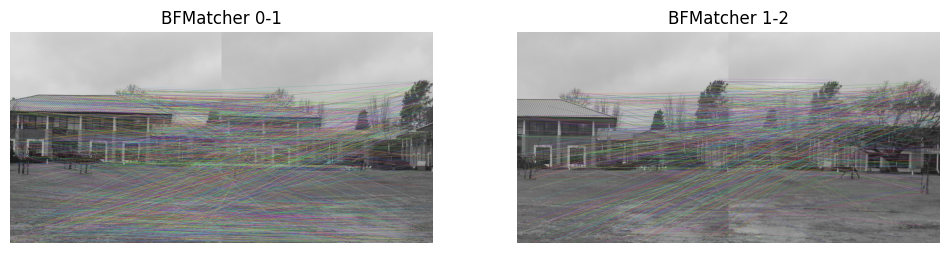

In [5]:
# Create BFMatcher object with L2 norm (for SIFT, SURF, etc.) and crossCheck enabled.
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

def bf_cross_check(desc1, desc2, matcher):
    # Ensure descriptors are float32 if necessary.
    desc1 = desc1.astype(np.float32)
    desc2 = desc2.astype(np.float32)
    
    # Perform matching. With crossCheck=True, only mutual matches are returned.
    matches = matcher.match(desc1, desc2)
    
    # Optionally, sort matches by distance (lower distance is better).
    return sorted(matches, key=lambda x: x.distance)

# Matching between image 0 and image 1.
matches01_cross = bf_cross_check(images_descriptors[0], images_descriptors[1], bf)
matched_img01_cross = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    matches01_cross, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Matching between image 1 and image 2.
matches12_cross = bf_cross_check(images_descriptors[1], images_descriptors[2], bf)
matched_img12_cross = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    matches12_cross, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display the matching images.
show_images([matched_img01_cross, matched_img12_cross], ["BFMatcher 0-1", "BFMatcher 1-2"])
print(f"Matches between image 0 and image 1: {len(matches01_cross)}")
print(f"Matches between image 1 and image 2: {len(matches12_cross)}")

 ### Lowe´s Ratio

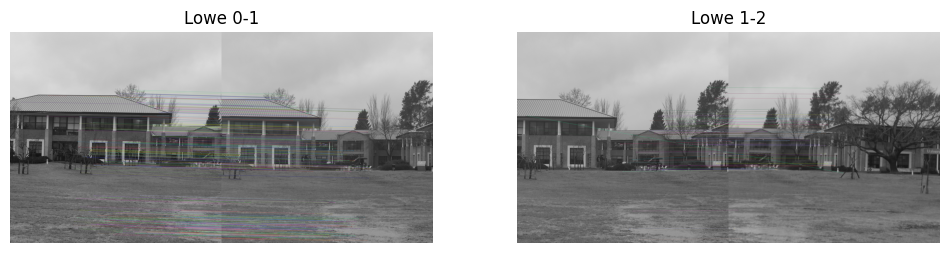

In [6]:
# Create BFMatcher object with L2 norm (e.g., for SIFT, SURF descriptors).
bf = cv2.BFMatcher(cv2.NORM_L2)

def bf_lowe_test(desc1, desc2, ratio=0.6):
    # Ensure descriptors are float32.
    desc1 = desc1.astype(np.float32)
    desc2 = desc2.astype(np.float32)
    
    # Perform knnMatch to find the two best matches for each descriptor.
    knn_matches = bf.knnMatch(desc1, desc2, k=2)
    
    # Apply Lowe's ratio test to filter matches.
    good_matches = []
    for m, n in knn_matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

# Perform matching between image 0 and image 1.
matches01_lowe = bf_lowe_test(images_descriptors[0], images_descriptors[1])
matched_img01_lowe = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    matches01_lowe, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Perform matching between image 1 and image 2.
matches12_lowe = bf_lowe_test(images_descriptors[1], images_descriptors[2])
matched_img12_lowe = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    matches12_lowe, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display the resulting matching images.
show_images([matched_img01_lowe, matched_img12_lowe], ["Lowe 0-1", "Lowe 1-2"])


### Cross-check vs Lowe´s Ratio

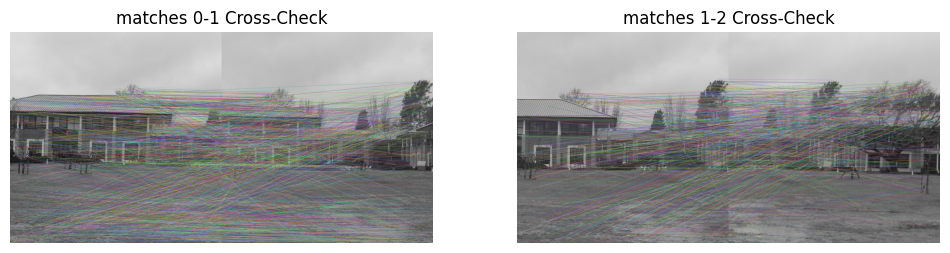

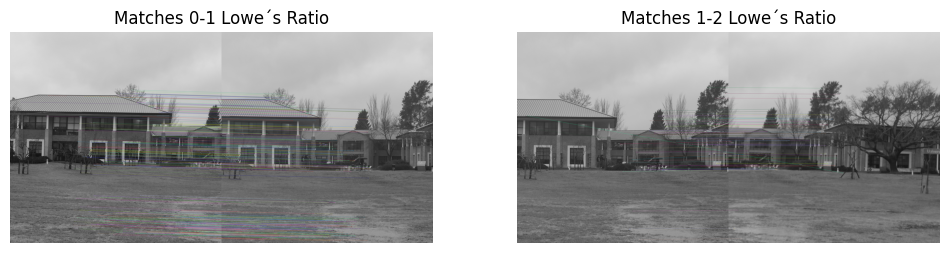

In [7]:
show_images([matched_img01_cross, matched_img12_cross], ["matches 0-1 Cross-Check", "matches 1-2 Cross-Check"])
show_images([matched_img01_lowe, matched_img12_lowe], ["Matches 0-1 Lowe´s Ratio", "Matches 1-2 Lowe´s Ratio"])

In [8]:
def normalize_points(points):
    """
    Normalize a set of 2D points so that the centroid is at the origin and the average distance to the origin is sqrt(2).
    Returns the normalized points in homogeneous coordinates and the normalization matrix.
    """
    points = np.array(points)
    # Compute centroid
    centroid = np.mean(points, axis=0)
    # Shift origin to centroid
    shifted = points - centroid
    # Compute scale such that average distance is sqrt(2)
    dists = np.linalg.norm(shifted, axis=1)
    mean_dist = np.mean(dists)
    scale = np.sqrt(2) / mean_dist

    # Construct normalization matrix
    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0,    0,                  1]])
    
    # Convert points to homogeneous coordinates and normalize
    points_hom = np.hstack([points, np.ones((points.shape[0], 1))])
    normalized_points = (T @ points_hom.T).T

    return normalized_points, T

def dlt(ori, dst):
    """
    Compute the homography matrix using the Direct Linear Transformation (DLT) algorithm
    with point normalization and SVD for improved numerical stability.
    """
    ori = np.array(ori)
    dst = np.array(dst)
    
    # Normalize points
    norm_ori, T_ori = normalize_points(ori)
    norm_dst, T_dst = normalize_points(dst)

    # Build matrix A using normalized points
    A = []
    for i in range(4):
        x, y, _ = norm_ori[i]
        xp, yp, _ = norm_dst[i]
        A.append([-x, -y, -1,  0,  0,  0, x * xp, y * xp, xp])
        A.append([ 0,  0,  0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)

    # Solve for h using SVD (the solution is the last column of V or last row of V^T)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1]
    H_normalized = h.reshape(3, 3)

    # Denormalize: H = inv(T_dst) * H_normalized * T_ori
    H = np.linalg.inv(T_dst) @ H_normalized @ T_ori

    # Normalize H so that H[2,2] is 1
    H /= H[2, 2]

    return H

def apply_homography(H, points):
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed_points = points_homogeneous @ H.T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    return transformed_points[:, :2]

def compute_precision(original_points, transformed_points):
    errors = np.linalg.norm(original_points - transformed_points, axis=1)
    return np.mean(errors)

p0 = [
    [2304, 1157],
    [2756, 1360],
    [2930, 1038],
    [2597, 1685],
]

p1 = [
    [1407, 1219],
    [1873, 1407],
    [2025, 1096],
    [1721, 1732],
    [2022, 1548]
]

p2 = [
    [466, 1381],
    [651, 1067],
    [311, 1714],
    [611, 1522]
]

p0_matched = np.array(p0)
p1_matched = np.array(p1[:-1])
H1 = dlt(p0_matched, p1_matched)

p1_matched_2 = np.array(p1[1:])
p2_matched = np.array(p2)
H2 = dlt(p1_matched_2, p2_matched)

p0_to_p1_transformed = apply_homography(H1, p0_matched)
p1_to_p2_transformed = apply_homography(H2, p1_matched_2)

precision_p0_p1 = compute_precision(p1_matched, p0_to_p1_transformed)
precision_p1_p2 = compute_precision(p2_matched, p1_to_p2_transformed)

precision_p0_p1, precision_p1_p2


(1.2758606932951651e-12, 1.24994451504292e-11)

## RANSAC

In [10]:
def ransac_homography_from_matches(kp1: list, kp2: list, matches: list, max_iterations: int = 1000, threshold: float = 5.0):
    max_inliers = 0
    best_inliers = []
    best_H = None

    for _ in range(max_iterations):
        sample_matches = np.random.choice(matches, 4, replace=False)

        # Get the point correspondences
        points1 = [kp1[m.queryIdx].pt for m in sample_matches]
        points2 = [kp2[m.trainIdx].pt for m in sample_matches]

        # Estimate homography using the improved DLT
        H = dlt(points1, points2)

        inliers = []
        for m in matches:
            pt1 = np.array([*kp1[m.queryIdx].pt, 1], dtype=np.float32)
            pt2 = np.array([*kp2[m.trainIdx].pt, 1], dtype=np.float32)

            projected_pt = H @ pt1
            projected_pt /= projected_pt[2]  # Normalize homogeneous coordinates
            # Calculate distance in image plane (x, y)
            distance = np.linalg.norm(projected_pt[:2] - pt2[:2])

            if distance < threshold:
                inliers.append(m)

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_inliers = inliers
            best_H = H

    return best_H, best_inliers

ransac_01_H, ransac_01_inliers = ransac_homography_from_matches(
    images_keypoints[0], images_keypoints[1], matches01_lowe, max_iterations=1000, threshold=5.0
)
ransac_12_H, ransac_12_inliers = ransac_homography_from_matches(
    images_keypoints[1], images_keypoints[2], matches12_lowe, max_iterations=1000, threshold=5.0
)

print(f"RANSAC 0-1: {len(ransac_01_inliers)} inliers")
print(f"RANSAC 1-2: {len(ransac_12_inliers)} inliers")


/tmp/ipykernel_13898/2881701892.py:22: RuntimeWarning: divide by zero encountered in divide
  projected_pt /= projected_pt[2]  # Normalize homogeneous coordinates
/tmp/ipykernel_13898/2881701892.py:22: RuntimeWarning: invalid value encountered in divide
  projected_pt /= projected_pt[2]  # Normalize homogeneous coordinates


RANSAC 0-1: 365 inliers
RANSAC 1-2: 49 inliers


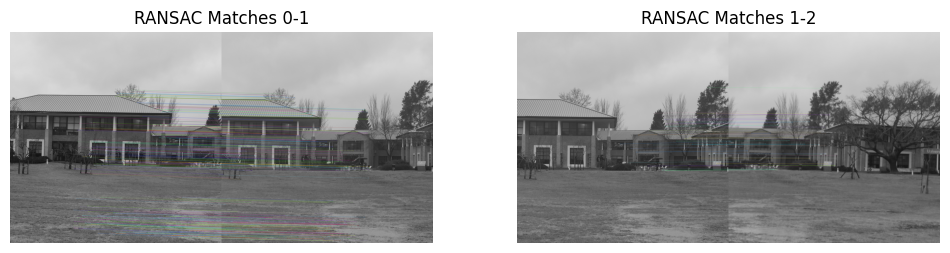

In [11]:
# Draw inliers
inlier_matches_01 = cv2.drawMatches(
    images[0], images_keypoints[0],
    images[1], images_keypoints[1],
    ransac_01_inliers, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
inlier_matches_12 = cv2.drawMatches(
    images[1], images_keypoints[1],
    images[2], images_keypoints[2],
    ransac_12_inliers, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
show_images([inlier_matches_01, inlier_matches_12], ["RANSAC Matches 0-1", "RANSAC Matches 1-2"])

In [13]:
# Extraer puntos de los inliers 0-1
pts_01_src = np.float32([images_keypoints[0][m.queryIdx].pt for m in ransac_01_inliers])
pts_01_dst = np.float32([images_keypoints[1][m.trainIdx].pt for m in ransac_01_inliers])

# Homografía usando OpenCV
H_cv2_01, mask_01 = cv2.findHomography(pts_01_src, pts_01_dst)

# Repetir para imágenes 1-2
pts_12_src = np.float32([images_keypoints[1][m.queryIdx].pt for m in ransac_12_inliers])
pts_12_dst = np.float32([images_keypoints[2][m.trainIdx].pt for m in ransac_12_inliers])

H_cv2_12, mask_12 = cv2.findHomography(pts_12_src, pts_12_dst)

print("Homografía 0 → 1 (OpenCV):\n", H_cv2_01)
print("Homografía 1 → 2 (OpenCV):\n", H_cv2_12)


Homografía 0 → 1 (OpenCV):
 [[ 1.05892660e+00  1.11399815e-02 -9.72054378e+02]
 [ 1.86440598e-02  1.03464887e+00  2.31346296e+01]
 [ 1.66752860e-05  5.07575682e-07  1.00000000e+00]]
Homografía 1 → 2 (OpenCV):
 [[ 1.09813126e+00 -4.39562001e-02 -1.50073882e+03]
 [ 8.10312701e-02  1.06997531e+00 -1.95781254e+02]
 [ 3.11982144e-05 -1.79334196e-06  1.00000000e+00]]


Bounds: -973 -156 4597 3123


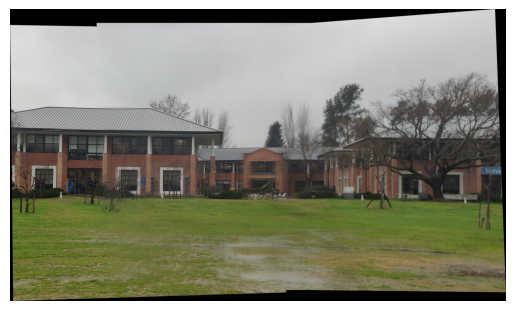

In [ ]:
def cylindrical_warp(img, f):
    h, w = img.shape[:2]
    xs, ys = np.meshgrid(np.arange(w), np.arange(h))
    xs_c = xs - w / 2
    ys_c = ys - h / 2
    theta = np.arctan(xs_c / f)
    h_ = ys_c / np.sqrt(xs_c**2 + f**2)
    map_x = (f * theta + w / 2).astype(np.float32)
    map_y = (f * h_ + h / 2).astype(np.float32)
    cyl = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return cyl

def compute_panorama_bounds(images, H_matrices):
    all_corners = []
    for img, H in zip(images, H_matrices):
        h, w = img.shape[:2]
        corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners, H)
        all_corners.append(warped_corners)
    all_corners = np.vstack(all_corners)
    x_min = int(np.floor(all_corners[:, 0, 0].min()))
    y_min = int(np.floor(all_corners[:, 0, 1].min()))
    x_max = int(np.ceil(all_corners[:, 0, 0].max()))
    y_max = int(np.ceil(all_corners[:, 0, 1].max()))
    return x_min, y_min, x_max, y_max

H0 = H_cv2_01
H1 = np.eye(3)
H2 = np.linalg.inv(H_cv2_12)
H_matrices = [H0, H1, H2]

focal_length = 5000
images = [cv2.imread(f'img/udesa_{i}.jpg') for i in range(3)]

images_cyl = [cylindrical_warp(img, focal_length) for img in images]

x_min, y_min, x_max, y_max = compute_panorama_bounds(images_cyl, H_matrices)
print("Bounds:", x_min, y_min, x_max, y_max)

translation = np.array([[1, 0, -x_min],
                        [0, 1, -y_min],
                        [0, 0, 1]])
pano_width = x_max - x_min
pano_height = y_max - y_min

warped_images = []
for idx, (img, H) in enumerate(zip(images_cyl, H_matrices)):
    warped = cv2.warpPerspective(img, translation @ H, (pano_width, pano_height))
    warped_images.append(warped)

accum = np.zeros((pano_height, pano_width, 3), dtype=np.float32)
weight_accum = np.zeros((pano_height, pano_width), dtype=np.float32)

for warped in warped_images:
    mask = np.any(warped > 0, axis=2).astype(np.uint8)
    mask_8u = (mask * 255).astype(np.uint8)
    dist = cv2.distanceTransform(mask_8u, cv2.DIST_L2, 3)
    weight = dist[..., np.newaxis]
    
    accum += warped.astype(np.float32) * weight
    weight_accum += dist

weight_accum_3c = np.repeat(weight_accum[..., np.newaxis], 3, axis=2)
panorama = accum / np.maximum(weight_accum_3c, 1e-6)
panorama = panorama.astype(np.uint8)

imshow(panorama)
